We need to change the action taken on each nodes. We are currently blocking all incoming actors. This is not a realistic actors movements on a network.

In [347]:
%load_ext autoreload
%autoreload 2

In [348]:
import sys
sys.path.append('../src/')
from random_graph import RandGraph
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [352]:
from random import randint

In [361]:
randint(1,10)

10

In [365]:
g = RandGraph()

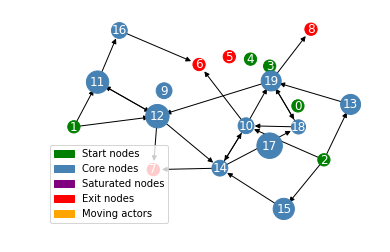

In [366]:
g.plot()

In [367]:
g.graph.edges(data=True)

OutEdgeDataView([(1, 11, {'pass_through': 6}), (1, 12, {'pass_through': 2}), (2, 10, {'pass_through': 7}), (2, 13, {'pass_through': 2}), (2, 15, {'pass_through': 3}), (10, 10, {'pass_through': 1}), (10, 19, {'pass_through': 4}), (10, 6, {'pass_through': 7}), (10, 14, {'pass_through': 9}), (11, 16, {'pass_through': 7}), (11, 12, {'pass_through': 8}), (12, 11, {'pass_through': 9}), (12, 12, {'pass_through': 2}), (12, 14, {'pass_through': 8}), (12, 7, {'pass_through': 6}), (13, 19, {'pass_through': 8}), (14, 10, {'pass_through': 8}), (14, 18, {'pass_through': 9}), (14, 7, {'pass_through': 3}), (15, 14, {'pass_through': 3}), (16, 6, {'pass_through': 1}), (18, 10, {'pass_through': 2}), (18, 19, {'pass_through': 8}), (19, 8, {'pass_through': 6}), (19, 18, {'pass_through': 10}), (19, 12, {'pass_through': 6})])

In [368]:
g.graph.nodes(data=True)

NodeDataView({0: {'actors': None}, 1: {'actors': None}, 2: {'actors': None}, 3: {'actors': None}, 4: {'actors': None}, 5: {'actors': None}, 6: {'actors': None}, 7: {'actors': None}, 8: {'actors': None}, 9: {'actors': None, 'capacity': 2}, 10: {'actors': None, 'capacity': 2}, 11: {'actors': None, 'capacity': 7}, 12: {'actors': None, 'capacity': 8}, 13: {'actors': None, 'capacity': 5}, 14: {'actors': None, 'capacity': 2}, 15: {'actors': None, 'capacity': 6}, 16: {'actors': None, 'capacity': 2}, 17: {'actors': None, 'capacity': 10}, 18: {'actors': None, 'capacity': 1}, 19: {'actors': None, 'capacity': 5}})

## `pass_trough`property

We need to define a new property of edges (intersection of roads) that will be used to move the number of actors from one node connected to another.

In [2]:
edges = [
    (0,1,{'pass_through':1}),
    (0,2,{'pass_through': 2}),
    (2,3,{'pass_through': 1}),
    (0,4,{'pass_through': 4})
]

h = nx.DiGraph()
h.add_edges_from(edges)
h.edges(data=True)

OutEdgeDataView([(0, 1, {'pass_through': 1}), (0, 2, {'pass_through': 2}), (0, 4, {'pass_through': 4}), (2, 3, {'pass_through': 1})])

This property cannot be less than 1. The sum of all output edges from one node is constant.

One action on one edge (intersection) will consist in increasing or decreasing traffic by a bounded percentage.

In [169]:
def get_pass_through_values(h, edge):
    pt_vals = []
    i = 0
    idx = 0

    origin, dest = edge
    for n1,n2 in h.edges(origin):
        pt_vals.append(h.edges[n1,n2]['pass_through'])
        if n2 == dest:
            idx = i
        i += 1
    return pt_vals, idx

In [4]:
def set_pass_through_values(h, pt_vals, node):
    i = 0
    for n1, n2 in h.edges(node):
        h.edges[n1,n2]['pass_through'] = pt_vals[i]
        i += 1
    return h

In [290]:
def update(pass_through, idx, value):
    # vector of pass_through values
    pt_vals = np.array(pass_through)
    if pt_vals.shape[-1] == 1:
        return pt_vals
#     if np.abs(value) > 0.5:
#         return pt_vals
    # mask
    mask = np.ones_like(pt_vals)
    mask[idx] = 0
    # inverted mask
    inv_mask = np.array(mask == False, dtype=int)
    # value update at index
    updated_idx = pt_vals * inv_mask * value + pt_vals * inv_mask
    updated_remaining = pt_vals * mask - pt_vals * mask / np.sum(pt_vals * mask) * value
    if (np.sum(updated_idx) >= 1) & (( updated_remaining - mask) >= np.zeros_like(mask)).all():
        epsilon = np.sum(pt_vals) - np.sum(updated_idx + updated_remaining)
        i = np.argmax(updated_idx + updated_remaining)
        epsilon_mask = np.zeros_like(pt_vals)
        epsilon_mask[i] = epsilon
        return updated_idx + updated_remaining + epsilon_mask
    else:
        return pt_vals

In [6]:
def action(graph, edge, value):
    origin, dest = edge
    pt_vals, idx = get_pass_through_values(graph, edge)
    updated_vals = update(pt_vals, idx, value)
    updated_graph = set_pass_through_values(graph, updated_vals, origin)
    return updated_graph

In [306]:
edges = [
    (0,1,{'pass_through':1}),
    (0,2,{'pass_through': 2}),
    (2,3,{'pass_through': 1}),
    (0,4,{'pass_through': 4})
]
h = nx.DiGraph()
h.add_edges_from(edges)
h.edges(data=True)

OutEdgeDataView([(0, 1, {'pass_through': 1}), (0, 2, {'pass_through': 2}), (0, 4, {'pass_through': 4}), (2, 3, {'pass_through': 1})])

In [307]:
origin = 0
dest = 1
pt_vals, idx = get_pass_through_values(h, (origin,dest))

In [308]:
pt_vals

[1, 2, 4]

In [309]:
vals = []
vals_series =[]
for i in range(1000):
    v = np.random.randn() 
    pt_vals = update(pt_vals, 0, v)
    vals.append(np.sum(pt_vals))
    vals_series.append(np.round(pt_vals).tolist())

In [310]:
pt_vals

array([ 1.00598403,  1.02014737,  4.9738686 ])

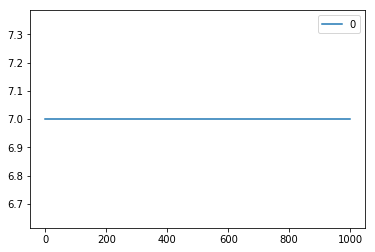

In [311]:
pd.DataFrame(vals).plot()
plt.show()

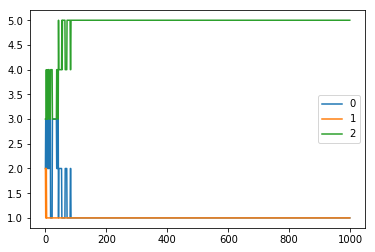

In [312]:
pd.DataFrame(vals_series).plot()
plt.show()

In [283]:
pt_vals[:3]

array([ 6.82410959, -1.48555829,  1.66144871])

In [136]:
((np.ones((3)) - np.random.randn(3)) >= np.zeros((3))).all()

False

In [161]:
import random

In [163]:
random.sample(pt_vals.tolist(),2)

[3.797468668491481, 0.8531374394941704]

In [343]:
edges = [
    (0,1,{'pass_through':1}),
    (0,2,{'pass_through': 2}),
    (2,3,{'pass_through': 1}),
    (2,5,{'pass_through': 5}),
    (0,4,{'pass_through': 4})
]
h = nx.DiGraph()
h.add_edges_from(edges)
h.edges(data=True)


vals = []
vals_series =[]
for i in range(1000):
    v = np.random.randn() 
    origin ,dest = random.sample([0,1,2,4],2)
    if (origin, dest) in h.edges():
        pt_vals, idx = get_pass_through_values(h, (origin,dest))
        pt_vals = update(pt_vals, 0, v)
        vals.append(np.sum(pt_vals))
        vals_series.append(pt_vals.tolist())

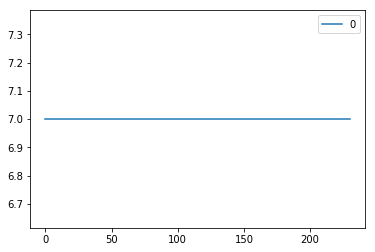

In [344]:
pd.DataFrame(vals).plot()
plt.show()

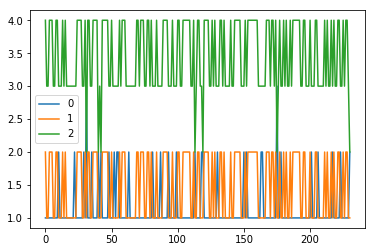

In [345]:
pd.DataFrame(vals_series, dtype=int).plot()
plt.show()

In [346]:
vals_series[:10]

[[1, 2, 4],
 [1.4069455336223315, 1.864351488792556, 3.728702977585112],
 [1.2816769569504416, 1.9061076810165196, 3.8122153620330392],
 [1, 2, 4],
 [1, 2, 4],
 [1, 2, 4],
 [1.8888410428009146, 1.7037196523996951, 3.4074393047993903],
 [1.036505370272704, 1.987831543242432, 3.975663086484864],
 [1, 2, 4],
 [1, 2, 4]]

In [342]:
random.sample([1,2,4],2)

[2, 4]